# Determining signal strength parameter $\mu$ with a CR measuring background normalization

## Measurement setup

Measurement with 2 regions:
- Signal region (SR)
- Control region for background normalization measurement (CR)

### Signal region (SR) containing signal and background

Number of events observed is distributed by a Poisson with parameter $b_{SR} + \mu \cdot s_{0}$ 

\begin{equation}
    N_{SR} \sim Poi\left( b_{SR} + \mu \cdot s_{0} \right)
\end{equation}

### Control region (CR)

Number of events observed is distributed by a Poisson with parameter $b_{CR}$ 

\begin{equation}
    N_{CR} \sim Poi\left( b_{CR} \right)
\end{equation}

Relation between the background component in the signal and control regions:

\begin{equation}
    b_{SR} = r \cdot b_{CR}
\end{equation}

where $r$ is assumed to be known to infinite precision.

## Model parameters

$\theta = (\mu, b_{CR})$

- POI: $\mu$
- NP: $b_{CR}$

## Test statistic

\begin{equation}
    t
    =
    -2 \log \frac{\mathcal{L} (\mu, \hat{\hat{\nu}} )}{ \mathcal{L}(\hat{\mu}, \hat{\nu}) }
\end{equation}

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

/Users/edy/lib/build/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Utility functions

In [2]:
def likelihood_poi(mu, n, bkg, s0=1.0, neg=False, log=False):
    """Return the value of the Poisson likelihood function, given the:
       - mu: signal strength parameter,
       - n: number of events observed,
       - bkg: expected number of background events,
       - s0: nominal number of signal events
       The total expected number of events is lambda = bkg + mu*s0.
       
       The `neg` argument just multiplies the likelihood by (-1).
       This is used for the minimize() function."""
    sig = mu * s0
    N_exp = bkg + sig
    if log:
        likelihood = poisson.logpmf(n, mu=N_exp)
    else:
        likelihood = poisson.pmf(n, mu=N_exp)
    
    if neg:
        return -likelihood
    else:
        return likelihood

In [3]:
def model_likelihood(mu, b_CR, SR_measured, CR_measured, s0=1.0, r=0.2, log=False, neg=False):
    
    b_SR = b_CR*r
    
    likelihood_SR = likelihood_poi(mu=mu, n=SR_measured, bkg=b_SR, s0=s0, log=log, neg=False)
    likelihood_CR = poisson.logpmf(CR_measured, mu=b_CR)
    if log:
        model_likelihood = likelihood_SR+likelihood_CR
    else:
        model_likelihood = likelihood_SR*likelihood_CR
    if neg:
        return -model_likelihood
    else:
        return model_likelihood

In [4]:
def ll_free(x, SR_measured, CR_measured, s0=1.0, r=0.2, log=True, neg=True):
    mu   = x[0]
    b_CR = x[1]
    ll = model_likelihood(mu, b_CR, SR_measured, CR_measured=CR_measured, s0=s0, r=r, log=log, neg=neg)
    return ll

In [5]:
def ll_cond(x, mu, SR_measured, CR_measured, s0=1.0, r=0.2, log=True, neg=True):
    b_CR = x
    ll = model_likelihood(mu, b_CR, SR_measured, CR_measured=CR_measured, s0=s0, r=r, log=log, neg=neg)
    return ll

In [6]:
def perform_fit(SR, CR, mu, r=0.2):
    
    fit_result_free = minimize(ll_free, x0=[1.0, 5000.0], args=(SR, CR,     1.0, r, True, True), method='Nelder-Mead')
    fit_result_cond = minimize(ll_cond, x0=[5000.0],      args=(mu, SR, CR, 1.0, r, True, True), method='Nelder-Mead')
    LL_free = -fit_result_free['fun'] # (-1)*(-log likelihood)
    LL_cond = -fit_result_cond['fun'] # (-1)*(-log likelihood)
    parameter_MLE_free = fit_result_free['x']
    parameter_MLE_cond = fit_result_cond['x']
    t =  -2.0*(LL_cond-LL_free)
    
    mu_fit_free = parameter_MLE_free[0]
    b_CR_free   = parameter_MLE_free[1]
    b_CR_cond   = parameter_MLE_cond
    
    return (LL_free, mu_fit_free, b_CR_free, LL_cond, b_CR_cond, t)

## Truth model

In [7]:
nExperiments = 2000

In [8]:
Z = 1.64
s0 = 1.0

In [9]:
b_SR_truth = 1000.0

In [10]:
b_CR_truth = 5000.0

In [11]:
r = b_SR_truth/b_CR_truth

## Hypotheses

### Null hypothesis $H_{0}$: There is only background in the SR

$H_{0}$ hypothesis parameters

SR

In [12]:
b_SR_H0   = 1000.0
s_SR_H0   = 0.0
SR_exp_H0 = b_SR_H0 + s_SR_H0
mup_H0    = s_SR_H0/s0

In [13]:
SR_events_H0 = poisson.rvs(mu=SR_exp_H0, loc=0.0, size=nExperiments)

CR

In [14]:
b_CR_exp_H0 = 5000.0

In [15]:
CR_events_H0 = poisson.rvs(mu=b_CR_exp_H0, loc=0.0, size=nExperiments)

### Alternative hypothesis $H_{1}$

$H_{1}$ hypothesis parameters

SR

In [16]:
b_SR_H1   = 1000.0
s_SR_H1   = 50
SR_exp_H1 = b_SR_H1 + s_SR_H1
mup_H1    = s_SR_H1/s0

In [17]:
SR_events_H1 = poisson.rvs(mu=SR_exp_H1, loc=0.0, size=nExperiments)

CR

In [18]:
b_CR_exp_H1 = 5000.0

In [19]:
CR_events_H1 = poisson.rvs(mu=b_CR_exp_H1, loc=0.0, size=nExperiments)

----

Text(0,0.5,'Frequency')

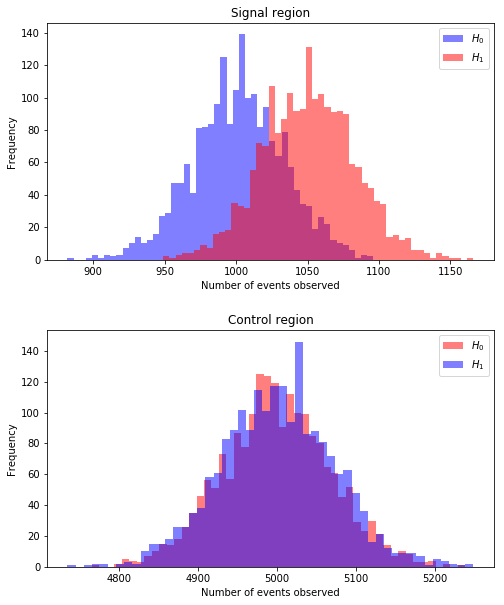

In [20]:
fig,axes = plt.subplots(nrows=2, figsize=(8,10))
fig.subplots_adjust(hspace=0.3)
ax = axes.flatten()
ax[0].hist(SR_events_H0, bins=50, color='b', alpha=0.5, label=r'$H_{0}$')
ax[0].hist(SR_events_H1, bins=50, color='r', alpha=0.5, label=r'$H_{1}$')
ax[0].set_title("Signal region")
ax[0].set_xlabel("Number of events observed")
ax[0].set_ylabel("Frequency")
ax[0].legend()
ax[1].hist(CR_events_H0, bins=50, color='r', alpha=0.5, label=r'$H_{0}$');
ax[1].hist(CR_events_H1, bins=50, color='b', alpha=0.5, label=r'$H_{1}$');
ax[1].set_title("Control region")
ax[1].legend()
ax[1].set_xlabel("Number of events observed")
ax[1].set_ylabel("Frequency")

In [21]:
model_likelihood(b_CR=5000.0, mu=10.0, SR_measured=SR_events_H0, CR_measured=CR_events_H0, log=True)

array([ -9.66610561,  -9.83484391,  -9.90802974, ..., -10.67188089,
        -9.87829224, -10.62655831])

In [22]:
fit_results_H0 = [perform_fit(SR, CR, mu=mup_H0, r=0.2) for SR, CR in zip(SR_events_H0, CR_events_H0)]
fit_results_H1 = [perform_fit(SR, CR, mu=mup_H0, r=0.2) for SR, CR in zip(SR_events_H1, CR_events_H1)]
fit_results_H0 = np.array(fit_results_H0)
fit_results_H1 = np.array(fit_results_H1)

## Distribution of $\hat{\mu},\hat{b}_{CR}$

Text(0.5,1,'Best fit $(\\hat{\\mu},\\hat{b}_{CR})$')

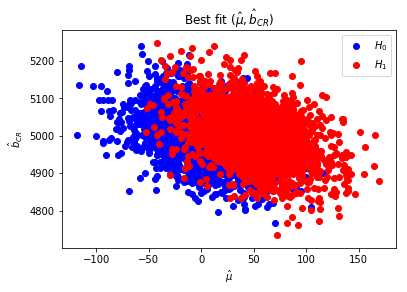

In [23]:
f,ax = plt.subplots()
ax.scatter(fit_results_H0[:,1], fit_results_H0[:,2], c='b', label=r"$H_{0}$")
ax.scatter(fit_results_H1[:,1], fit_results_H1[:,2], c='r', label=r"$H_{1}$")
ax.set_xlabel(r'$\hat{\mu}$')
ax.set_ylabel(r'$\hat{b}_{CR}$')
ax.legend()
ax.set_title(r"Best fit $(\hat{\mu},\hat{b}_{CR})$")

In [24]:
np.corrcoef(fit_results_H0[:,0], fit_results_H1[:,1])

array([[ 1.        , -0.02992503],
       [-0.02992503,  1.        ]])

## Distribution of $\log \mathcal{L}$

/Users/edy/lib/build/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


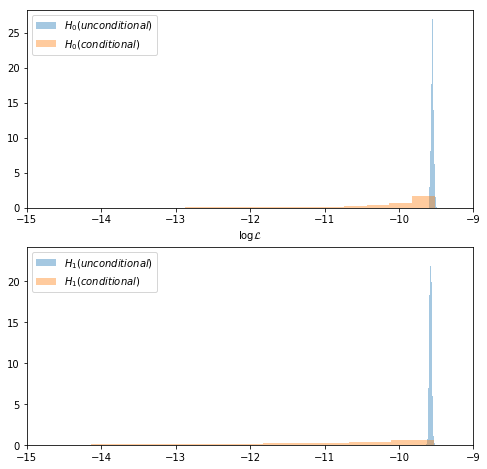

In [25]:
f,a = plt.subplots(nrows=2, figsize=(8,8))
a = a.flatten()
a[0].hist(fit_results_H0[:,0], bins=20, alpha=0.4, label='$H_{0} (unconditional)$', normed=True);
a[0].hist(fit_results_H0[:,3], bins=20, alpha=0.4, label='$H_{0} (conditional)$',   normed=True);
a[1].hist(fit_results_H1[:,0], bins=20, alpha=0.4, label='$H_{1} (unconditional)$', normed=True);
a[1].hist(fit_results_H1[:,3], bins=20, alpha=0.4, label='$H_{1} (conditional)$',   normed=True);
a[0].set_xlim(-15, -9)
a[1].set_xlim(-15, -9)
a[0].set_xlabel('$\log \mathcal{L}$')
a[0].set_xlabel('$\log \mathcal{L}$')
a[0].legend()
a[1].legend()

## Distribution of $t$

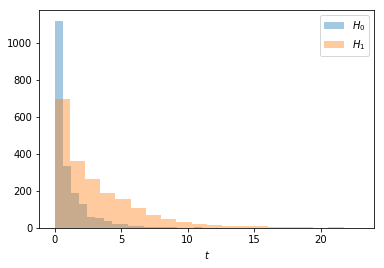

In [26]:
f,a = plt.subplots()
a.hist(fit_results_H0[:,5], bins=20, alpha=0.4, label='$H_{0}$')
a.hist(fit_results_H1[:,5], bins=20, alpha=0.4, label='$H_{1}$')
a.set_xlabel("$t$")
a.legend()